
# Table Of Contents

- [GA DSIF 13 - Capstone](#ga-dsif-13---capstone)

  - [Import Libraries](#Import-Libraries)

  - [Set Seeds](#Set-Seeds)

  - [Data Preprocessing](#Data-Preprocessing)
    - [Image And CSV Data Paths](###Image-And-CSV-Data-Paths)
    - [Image Transformation Pipeline](###Image-Transformation-Pipeline)
    - [Encode Cateogrical To Numerical Data Type](###Encode-Cateogrical-To-Numerical-Data-Type)
  
  - [Type Classification With Pre-trained Models](#Type-Classification-With-Pre-trained-Models)
    - [Data Preparation For Type Classification](###Data-Preparation-For-Type-Classification)
    - [Type Classification: ResNet50 (baseline)](###Type-Classification:-ResNet50-(baseline))
    - [Type Classification: ResNet152](###Type-Classification:-ResNet152)
    - [Type Classification: EfficientNet_V2_L](###Type-Classification:-EfficientNet_V2_L)
    - [Type Classification: RexNet200](###Type-Classification:-RexNet200)

  - [Type Test Data Evaluation](#Type-Test-Data-Evaluation)
    - [Type Load Selected Model](###Type-Load-Selected-Model)
    - [Type Accuracy Evaluation](###Type-Accuracy-Evaluation)
    - [Type Classification Report](###Type-Classification-Report)
    - [Type Display Misclassified Sample](###Type-Display-Misclassified-Sample)
    - [Type Prediction EDA And Visualisation](###Type-Prediction-EDA-And-Visualisation)

  - [Side Classification With Pre-trained Models](#Side-Classification-With-Pre-trained-Models)
    - [Data Preparation For Side Classification](###Data-Preparation-For-Side-Classification)
    - [Side Classification: ResNet50 (baseline)](###Side-Classification:-ResNet50-(baseline))

  - [Side Test Data Evaluation](#Side-Test-Data-Evaluation)
    - [Side Load Selected Model](###Side-Load-Selected-Model)
    - [Side Accuracy Evaluation](###Side-Accuracy-Evaluation)
    - [Side Classification Report](###Side-Classification-Report)
    - [Side Display Misclassified Sample](###Side-Display-Misclassified-Sample)
    - [Side Prediction EDA And Visualisation](###Side-Prediction-EDA-And-Visualisation)

  - [Grade Regression With Pre-trained Models](#Grade-Regression-With-Pre-trained-Models)
    - [Data Preparation For Grade Regression](###Data-Preparation-For-Grade-Regression)
    - [Grade Regression: ResNet50 (baseline)](###Grade-Regression:-ResNet50-(baseline))
    - [Grade Regression: ResNet152](###Grade-Regression:-ResNet152)
    - [Grade Regression: EfficientNet_V2_L](###Grade-Regression:-EfficientNet_V2_L)
    - [Grade Regression: RexNet200](###Grade-Regression:-RexNet200)
    - [Grade Regression: VGG16](###Grade-Regression:-VGG16)

  - [Grade Test Data Evaluation](#Grade-Test-Data-Evaluation)
    - [Grade Load Selected Model](###Grade-Load-Selected-Model)
    - [Grade Prediction EDA And Visualisation](###Grade-Prediction-EDA-And-Visualisation)

  - [Grade Classification With Pre-trained Models](#Grade-Classification-With-Pre-trained-Models)
    - [Data Preparation For Grade Classification](###Data-Preparation-For-Grade-Classification)
    - [Grade Classification: ResNet152](###Grade-Classification:-ResNet152)

# Import Libraries

In [1]:
# Imports:

# EDA
import pandas as pd

# train test split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

# timm models
import timm

# pytorch
import torch

# torchvision models
from torchvision.models import (
    resnet50, ResNet50_Weights,
    resnet152,  ResNet152_Weights,
    efficientnet_v2_l, EfficientNet_V2_L_Weights
    )

# data augmentations and transformations
import torchvision.transforms as transforms

# scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# nn loss functions and model layers 
import torch.nn as nn 

# optimiser
import torch.optim as optim

# use GPU is cuda is available
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Set Seeds
[TOC](#Table-Of-Contents)

In [2]:
from helper_functions import seed_everything

seed_everything(22)

# Data Preprocessing
[TOC](#Table-Of-Contents)

### Image And CSV Data Paths

In [3]:
crop_path = '..\Img label test\Raw Crop'
crop_csv = '..\Img label test\\raw_crop.csv'

concat_path = '..\Img label test\Raw Concat'
concat_csv = '..\Img label test\\raw_concat.csv'

### Image Transformation Pipeline

In [4]:
# reduce overfitting (learning importance features only instead of all features) by augmenting data with variation (translation, rotation, skew, crop, zoom, contrast).
# it also serves to create more data for modelling
# standardise mean, and std deviation using ImageNet's mean and std. (Depending on which image dataset pre-trained models were trained on)
# https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((224,224)), # reszie to fit pre-trained model input (h,w)
        transforms.RandomAffine(degrees= 10, translate= (0.05,0.05), shear= 5),
        transforms.ColorJitter(hue= 0.05, saturation= 0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
]),
    'val': transforms.Compose([
        transforms.Resize((224,224)), # reszie to fit pre-trained model input (h,w)
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])
}

### Encode Cateogrical To Numerical Data Type

In [5]:
# encode categorical to numerical data type for modelling 

type_dict = {
    'BASEBALL': 0,
    'BASKETBALL' : 1,
    'FOOTBALL' : 2,
    'HOCKEY' : 3,
    'LEAGUE' : 4,
    'MISC' : 5,
    'MULTI-SPORT' : 6,
    'NON-SPORT' : 7,
    'SOCCER' : 8,
    'TCG' : 9,
    'WRESTLING' : 10,
    'GOLF' : 11,
}

side_dict = {
    'Back' : 0,
    'Front': 1
}

grade_dict = {
    1 : 0,
    1.5 : 1,
    2 : 2,
    2.5: 3,
    3 : 4,
    3.5 : 5,
    4 : 6,
    4.5 : 7,
    5 : 8,
    5.5 : 9,
    6 : 10,
    6.5 : 11,
    7 : 12,
    7.5 : 13,
    8 : 14,
    8.5 : 15,
    9 : 16,
    10 : 17
}

# Type Classification With Pre-trained Models
[TOC](#Table-Of-Contents)

### Data Preparation For Type Classification

In [6]:
# set target column and the corresponding image and csv file path 
target = 'Type'
img_path = concat_path
csv_path = concat_csv

# set the max sample size per target group. To limit the data used for modelling, as well as reduce imbalanced data
max_sample = 2000

# create df for modelling, restricting each target group sample size
# note: Groupby has a warning that requires explict selection of the grouping columns after groupby to slience the warning, or use include_groups = True/False
raw_data = pd.read_csv(csv_path, usecols=['File_name', 'Grade', 'Side', 'Type'])
raw_data['GradeClass'] = raw_data['Grade'].map(lambda x: grade_dict[x])
data = raw_data.groupby(target, group_keys=False, as_index=False)[['File_name', 'Grade', 'Side', 'Type', 'GradeClass']].apply(lambda x: x if len(x) < max_sample else x.sample(max_sample, random_state=22)).reset_index()
data.drop(columns='index', inplace=True)

# encode categorical to numerical data type
data['Side'] = data['Side'].map(lambda x: side_dict[x])
data['Type'] = data['Type'].map(lambda x: type_dict[x])

# check data shape, distribution, and null values
print(data.info())
print('\n')
print(data[target].value_counts())
print('\n')

# define train/val/test split ratio
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# split data in to train, val and test set
train_df, val_df = train_test_split(data, stratify=data[target], test_size=(1-train_ratio), random_state=22)
val_df, test_df = train_test_split(val_df, stratify=val_df[target], test_size = test_ratio/ (validation_ratio + test_ratio), random_state=22)

# check number of samples in train, val and test
print(f'Train samples: {len(train_df):,}')
print(f'Validation samples: {len(val_df):,}')
print(f'Test samples: {len(test_df):,}')
print('\n')

# create train, val and test data with the images and labels, with corresponding transformation
from helper_functions import CardData

train_data = CardData(img_path, train_df, transform = data_transforms['train'])
val_data = CardData(img_path, val_df, transform = data_transforms['val'])
test_data = CardData(img_path, test_df, transform = data_transforms['val'])


# # establish weight based on the reciprocal of class count (e.g lower class counts have higher weights)
# class_count = train_df[data_column].value_counts()
# sample_weights = [i/class_count[i] for i in train_df[data_column].values]

# # set replacement = True to oversample minority classes
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples= len(train_df), replacement=True)

# create dataloader with weighted sampling
from helper_functions import loader

# train_loader, val_loader, test_loader = loader(train_data, val_data, test_data, sampler)
train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15018 entries, 0 to 15017
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   File_name   15018 non-null  object 
 1   Grade       15018 non-null  float64
 2   Side        15018 non-null  int64  
 3   Type        15018 non-null  int64  
 4   GradeClass  15018 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 586.8+ KB
None


Type
0     2000
1     2000
2     2000
7     2000
8     2000
9     2000
3     1662
10     576
5      347
6      275
4      120
11      38
Name: count, dtype: int64


Train samples: 11,263
Validation samples: 2,253
Test samples: 1,502


Train samples: 11263
Val samples: 2253
Test samples: 1502


In [7]:
# check tensor shape
images, grade, side, type, grade_class = next(iter(train_loader))
print(images.shape)
print(grade.shape)
print(side.shape)
print(type.shape)
print(grade_class.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])


### Type Classification: ResNet50 (baseline)

Sequential(
  (0): Linear(in_features=2048, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=12, bias=True)
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current loss: 0.6396, Current acc:81.4913
Best loss: 0.6396
Starting Epoch: 2
Epoch: 2, Current loss: 0.5394, Current acc:83.6218
Best loss: 0.5394
Training Completed


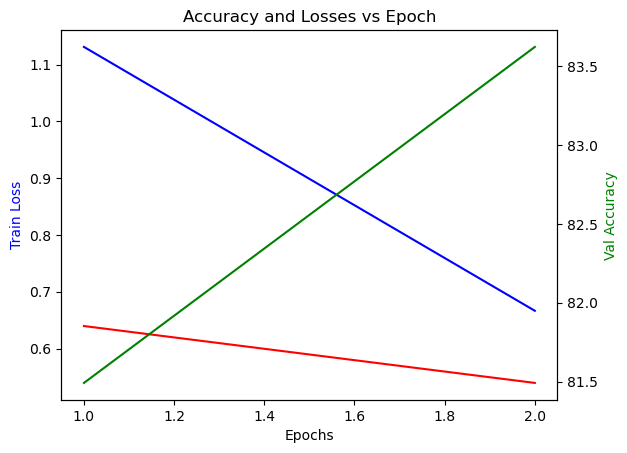

In [8]:
# https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e

# set up model work flow
from helper_functions import classification_model_train

# define number of classes for model head
num_classes = data[target].nunique()

# load pretrained model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))

# verify model head
print(model.fc)
print('\n')

# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# # unfreeze parameter update for the following layers
# for param in model.layer4.parameters():
#     param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_mode = 'No'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

loss_criterion = nn.CrossEntropyLoss()
epochs = 2
patience = 7

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

result = classification_model_train(target, save_mode, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Type Classification: ResNet152

Sequential(
  (0): Linear(in_features=2048, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=12, bias=True)
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current loss: 0.7847, Current acc:77.9849
Best loss: 0.7847
Starting Epoch: 2
Epoch: 2, Current loss: 0.6647, Current acc:79.9379
Best loss: 0.6647
Training Completed


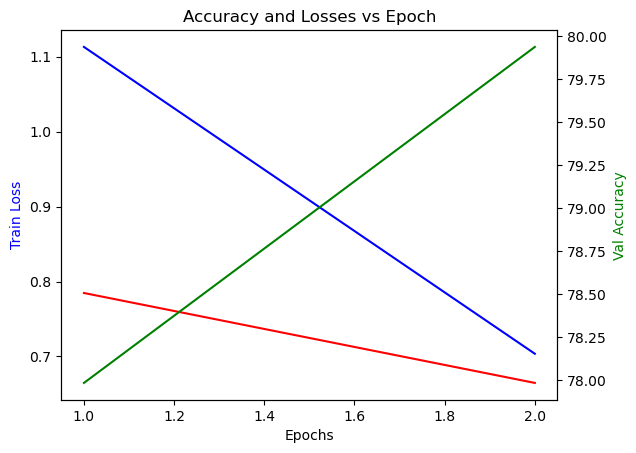

In [9]:
# set up model work flow
from helper_functions import classification_model_train

# define number of classes for model head
num_classes = data[target].nunique()

# load pretrained model
model = resnet152(weights=ResNet152_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))

# verify model head
print(model.fc)
print('\n')

# Trial and error of unfreezing layers to get lower error and higher accuracy 
# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameter update for the following layers
# for param in model.layer2.parameters():
#     param.requires_grad = True

# for param in model.layer3.parameters():
#     param.requires_grad = True

# for param in model.layer4.parameters():
#     param.requires_grad = True

# unfreeze parameter for final layer
for param in model.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_mode = 'No'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

# The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model.
loss_criterion = nn.CrossEntropyLoss()
epochs = 2
patience = 7

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

result = classification_model_train(target, save_mode, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Type Classification: EfficientNet_V2_L

Sequential(
  (0): Linear(in_features=1280, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=12, bias=True)
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current loss: 0.9439, Current acc:71.1940
Best loss: 0.9439
Starting Epoch: 2
Epoch: 2, Current loss: 0.8791, Current acc:72.8362
Best loss: 0.8791
Training Completed


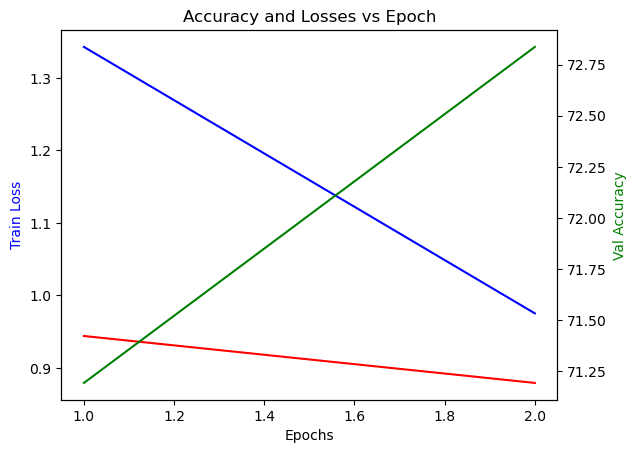

In [10]:
# set up model work flow
from helper_functions import classification_model_train

# define number of classes for model head
num_classes = data[target].nunique()

# load pretrained model
model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
                                # nn.Dropout(p=0.4, inplace=True),
                                nn.Linear(in_features, 640),
                                nn.ReLU(),
                                nn.Linear(640, num_classes))

# verify model head
print(model.classifier)
print('\n')

# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameter update for the following layers
# for param in model.features[8].parameters():
#     param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_mode = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

loss_criterion = nn.CrossEntropyLoss()
epochs = 2
patience = 7

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

result = classification_model_train(target, save_mode, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Type Classification: RexNet200

Sequential(
  (0): Linear(in_features=2560, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=12, bias=True)
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current loss: 0.6211, Current acc:81.4470
Best loss: 0.6211
Starting Epoch: 2
Epoch: 2, Current loss: 0.5455, Current acc:84.1101
Best loss: 0.5455
Training Completed


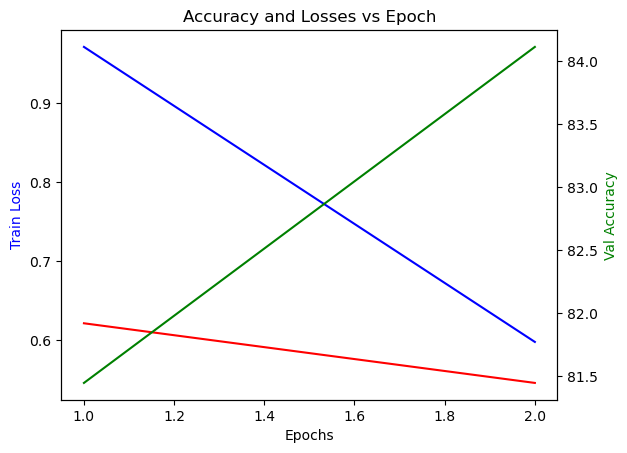

In [11]:
# set up model work flow
from helper_functions import classification_model_train

# define number of classes for model head
num_classes = data[target].nunique()

# load pretrained model
model = timm.create_model('rexnet_200', pretrained=True, num_classes=num_classes)

# check model architecture
# print(model)

# modify model head layer
in_features = model.head.fc.in_features
model.head.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))

# verify model head
print(model.head.fc)
print('\n')

# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameter update for the following layers
# for param in model.features[12].parameters():
#     param.requires_grad = True

# for param in model.features[13].parameters():
#     param.requires_grad = True

# for param in model.features[14].parameters():
#     param.requires_grad = True

# for param in model.features[15].parameters():
#     param.requires_grad = True

# for param in model.features[16].parameters():
#     param.requires_grad = True

for param in model.head.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_mode = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

loss_criterion = nn.CrossEntropyLoss()
epochs = 2
patience = 7

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

result = classification_model_train(target, save_mode, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

# Type Test Data Evaluation
[TOC](#Table-Of-Contents)

### Type Load Selected Model

In [12]:
# load Type or Side model
model_path = r'..\Img label test\model'
load_model = 'ResNet152_Type_epoch_8_val_loss_0.1983_val_acc_95.3839.pth'

# Select Type or Side
target = 'Type'

# define number of classes for model head
num_classes = data[target].nunique()

# instantiate the correct model and head layer. Copy from relevant train cells
model = resnet152()
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))

# load weights from save model
model.load_state_dict(torch.load(f'{model_path}\{load_model}', weights_only=True))

# reload loaders without sampling replacement
train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

Train samples: 11263
Val samples: 2253
Test samples: 1502


### Type Accuracy Evaluation

In [13]:
# Test data accuracy evaluation
from helper_functions import data_acc

data_acc(target, model, test_loader)

Model accuracy: 94.61%


### Type Classification Report

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       200
           1       0.96      0.94      0.95       200
           2       0.97      0.96      0.97       200
           3       0.96      0.97      0.97       166
           4       0.67      0.50      0.57        12
           5       1.00      0.83      0.91        35
           6       0.58      0.56      0.57        27
           7       0.92      0.96      0.94       200
           8       0.96      0.96      0.96       200
           9       0.99      0.99      0.99       200
          10       0.91      0.91      0.91        58
          11       1.00      0.75      0.86         4

    accuracy                           0.95      1502
   macro avg       0.90      0.86      0.88      1502
weighted avg       0.95      0.95      0.95      1502



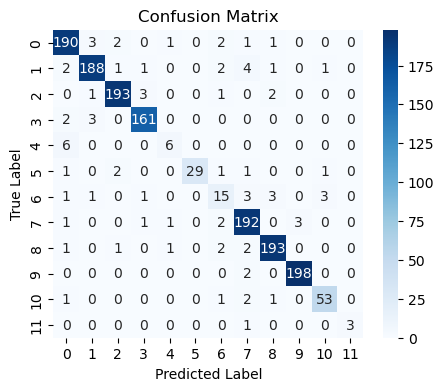

AUC: 0.9692
AUC: 0.9669
AUC: 0.9802
AUC: 0.9827
AUC: 0.7490
AUC: 0.9143
AUC: 0.7740
AUC: 0.9739
AUC: 0.9794
AUC: 0.9938
AUC: 0.9552
AUC: 0.8750


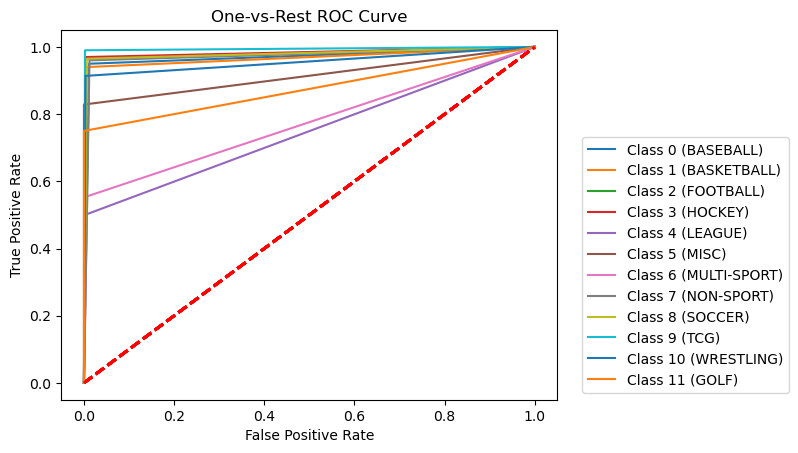

In [14]:
# Classificaton report
from helper_functions import eval_report

eval_report(target, model, test_loader)

### Type Display Misclassified Sample

In [15]:
from helper_functions import print_misclass

# set number of misclassed samples to display. Default: 5 samples
num_samples = 2

# print_misclass(target, model, test_loader, num_samples)

### Type Prediction EDA and Visualisation

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1502 entries, 4896 to 6116
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   File_name   1502 non-null   object 
 1   Grade       1502 non-null   float64
 2   Side        1502 non-null   int64  
 3   Type        1502 non-null   int64  
 4   GradeClass  1502 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 70.4+ KB


In [17]:
from helper_functions import classification_predict

predict = classification_predict(model, test_loader)

test_df['predicted'] = predict

type_num = {
    0 : 'BASEBALL',
    1 : 'BASKETBALL',
    2 : 'FOOTBALL',
    3 : 'HOCKEY',
    4 : 'LEAGUE',
    5 : 'MISC',
    6 : 'MULTI-SPORT',
    7 : 'NON-SPORT',
    8 : 'SOCCER',
    9 : 'TCG',
    10 : 'WRESTLING',
    11 : 'GOLF',
}

test_df['predicted'] = test_df['predicted'].map(lambda x: type_num[x])
test_df[target] = test_df[target].map(lambda x: type_num[x])

incorrect_df = test_df[test_df['predicted'] != test_df[target]]

print(f'Number of incorrect type classification: {len(incorrect_df)}')

Number of incorrect type classification: 81


In [18]:
# save csv
# test_df.to_csv(f'{target}_predictions.csv')

In [19]:
incorrect_df = incorrect_df[['File_name', 'Type', 'predicted']]
incorrect_df.head()

,File_name,Type,predicted
2079,PSA_87134843_with_fugitive_ink_technology_Yes_...,BASKETBALL,MULTI-SPORT
11792,PSA_87129647_with_fugitive_ink_technology_Yes_...,SOCCER,MULTI-SPORT
3074,PSA_87110375_with_fugitive_ink_technology_Yes_...,BASKETBALL,HOCKEY
12605,PSA_87097392_with_fugitive_ink_technology_Yes_...,TCG,NON-SPORT
5936,PSA_87134252_with_fugitive_ink_technology_Yes_...,FOOTBALL,HOCKEY


# Side Classification With Pre-trained Models
[TOC](#Table-Of-Contents)

### Data Preparation For Side Classification

In [20]:
# set target column and the corresponding image and csv file path 
target = 'Side'
img_path = crop_path
csv_path = crop_csv

# set the max sample size per target group. To limit the data used for modelling, as well as reduce imbalanced data
max_sample = 5000

# create df for modelling, restricting each target group sample size
# note: Groupby has a warning that requires explict selection of the grouping columns after groupby to slience the warning, or use include_groups = True/False
raw_data = pd.read_csv(csv_path, usecols=['File_name', 'Grade', 'Side', 'Type'])
raw_data['GradeClass'] = raw_data['Grade'].map(lambda x: grade_dict[x])
data = raw_data.groupby(target, group_keys=False, as_index=False)[['File_name', 'Grade', 'Side', 'Type', 'GradeClass']].apply(lambda x: x if len(x) < max_sample else x.sample(max_sample, random_state=22)).reset_index()
data.drop(columns='index', inplace=True)

# encode categorical to numerical data type
data['Side'] = data['Side'].map(lambda x: side_dict[x])
data['Type'] = data['Type'].map(lambda x: type_dict[x])

# check data shape, distribution, and null values
print(data.info())
print('\n')
print(data[target].value_counts())
print('\n')

# define train/val/test split ratio
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# split data in to train, val and test set
train_df, val_df = train_test_split(data, stratify=data[target], test_size=(1-train_ratio), random_state=22)
val_df, test_df = train_test_split(val_df, stratify=val_df[target], test_size = test_ratio/ (validation_ratio + test_ratio), random_state=22)

# check number of samples in train, val and test
print(f'Train samples: {len(train_df):,}')
print(f'Validation samples: {len(val_df):,}')
print(f'Test samples: {len(test_df):,}')
print('\n')

# create train, val and test data with the images and labels, with corresponding transformation
from helper_functions import CardData

train_data = CardData(img_path, train_df, transform = data_transforms['train'])
val_data = CardData(img_path, val_df, transform = data_transforms['val'])
test_data = CardData(img_path, test_df, transform = data_transforms['val'])


# # establish weight based on the reciprocal of class count (e.g lower class counts have higher weights)
# class_count = train_df[data_column].value_counts()
# sample_weights = [i/class_count[i] for i in train_df[data_column].values]

# # set replacement = True to oversample minority classes
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples= len(train_df), replacement=True)

# create dataloader with weighted sampling
from helper_functions import loader

train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   File_name   10000 non-null  object 
 1   Grade       10000 non-null  float64
 2   Side        10000 non-null  int64  
 3   Type        10000 non-null  int64  
 4   GradeClass  10000 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 390.8+ KB
None


Side
0    5000
1    5000
Name: count, dtype: int64


Train samples: 7,500
Validation samples: 1,500
Test samples: 1,000


Train samples: 7500
Val samples: 1500
Test samples: 1000


### Side Classification: ResNet50 (baseline)

Sequential(
  (0): Linear(in_features=2048, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=2, bias=True)
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current loss: 0.1293, Current acc:95.4000
Best loss: 0.1293
Starting Epoch: 2
Epoch: 2, Current loss: 0.1159, Current acc:96.4000
Best loss: 0.1159
Training Completed


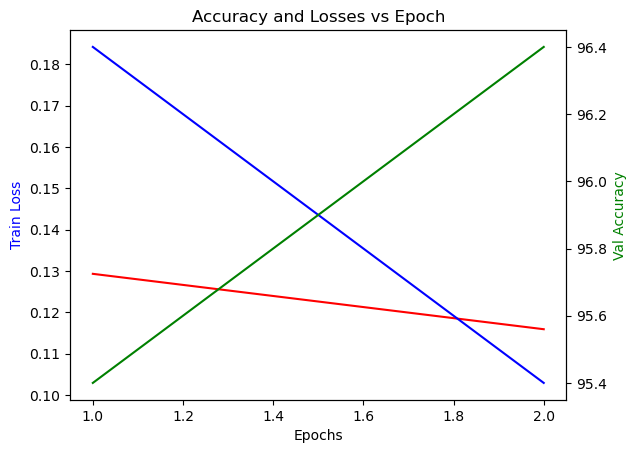

In [21]:
# set up model work flow
from helper_functions import classification_model_train

# define number of classes for model head
num_classes = data[target].nunique()

# load pretrained model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))

# verify model head
print(model.fc)
print('\n')

# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# Trial and error of unfreezing layers to get lower error and higher accuracy 

# unfreeze parameter update for the following layers
# for param in model.layer4.parameters():
#     param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_mode = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

# The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model.
loss_criterion = nn.CrossEntropyLoss()
epochs = 2
patience = 7

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

result = classification_model_train(target, save_mode, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

# Side Test Data Evaluation
[TOC](#Table-Of-Contents)

### Side Load Selected Model

In [22]:
# load model
model_path = r'..\Img label test\model'
load_model = 'ResNet_Side_epoch_1_val_loss_0.0466_val_acc_98.8000.pth'

target = 'Side'

# define number of classes for model head
num_classes = data[target].nunique()

# load model and head
model = resnet50()
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))


# load weights from save model
model.load_state_dict(torch.load(f'{model_path}\{load_model}', weights_only=True))

# reload loaders without sampling replacement
train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

Train samples: 7500
Val samples: 1500
Test samples: 1000


### Side Accuracy Evaluation

In [23]:
# Test data accuracy evaluation
from helper_functions import data_acc

data_acc(target, model, test_loader)

Model accuracy: 99.00%


### Side Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



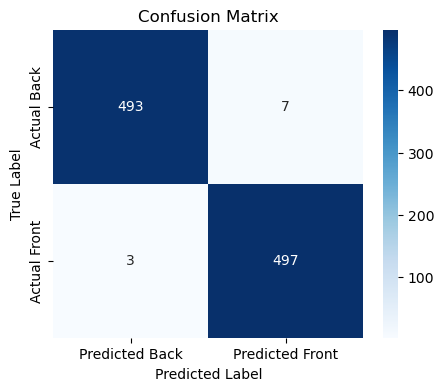

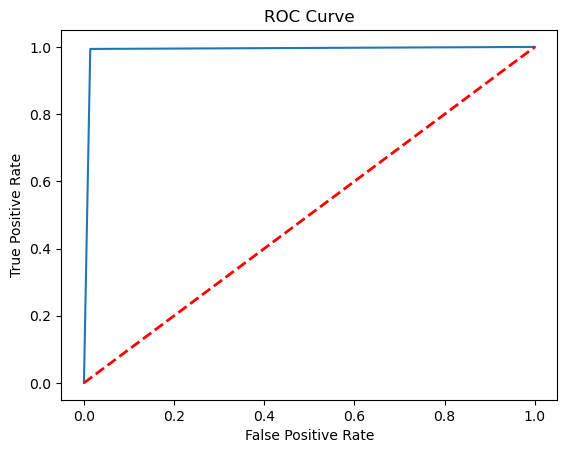

AUC: 0.9900


In [24]:
# Classificaton report
from helper_functions import eval_report

eval_report(target, model, test_loader)

### Side Display Misclassified Sample


In [25]:
from helper_functions import print_misclass

# set number of misclassed samples to display. Default: 5 samples
num_samples = 5

# print_misclass(target, model, test_loader, num_samples)

### Side Prediction EDA And Visualisation

In [26]:
from helper_functions import classification_predict

predict = classification_predict(model, test_loader)

test_df['predicted'] = predict

side_num = {
    0 : 'Back',
    1 : 'Front'
}

test_df['predicted'] = test_df['predicted'].map(lambda x: side_num[x])
test_df[target] = test_df[target].map(lambda x: side_num[x])

incorrect_df = test_df[test_df['predicted'] != test_df[target]]

print(f'Number of incorrect side classification: {len(incorrect_df)}')

Number of incorrect side classification: 10


In [27]:
# save csv
# test_df.to_csv(f'{target}_predictions.csv')

In [28]:
incorrect_df = incorrect_df[['File_name', 'Side', 'predicted']]
incorrect_df.head()

,File_name,Side,predicted
7074,PSA_87134257_with_fugitive_ink_technology_Yes_...,Front,Back
5442,PSA_87118089_with_fugitive_ink_technology_Yes_...,Front,Back
2034,PSA_87128812_No_2023_POKEMON_JAPANESE_COIN_PRO...,Back,Front
1507,PSA_78394322_with_fugitive_ink_technology_Yes_...,Back,Front
1711,PSA_87121839_with_fugitive_ink_technology_Yes_...,Back,Front


# Grade Regression With Pre-trained Models
[TOC](#Table-Of-Contents)

### Data Preparation For Grade Regression

In [29]:
# set target column and the corresponding image and csv file path 
target = 'Grade'
img_path = concat_path
csv_path = concat_csv

# set the max sample size per target group. To limit the data used for modelling, as well as reduce imbalanced data
max_sample = 2000

# create df for modelling, restricting each target group sample size
# note: Groupby has a warning that requires explict selection of the grouping columns after groupby to slience the warning, or use include_groups = True/False
raw_data = pd.read_csv(csv_path, usecols=['File_name', 'Grade', 'Side', 'Type'])
raw_data['GradeClass'] = raw_data['Grade'].map(lambda x: grade_dict[x])
data = raw_data.groupby(target, group_keys=False, as_index=False)[['File_name', 'Grade', 'Side', 'Type', 'GradeClass']].apply(lambda x: x if len(x) < max_sample else x.sample(max_sample, random_state=22)).reset_index()
data.drop(columns='index', inplace=True)

# encode categorical to numerical data type
data['Side'] = data['Side'].map(lambda x: side_dict[x])
data['Type'] = data['Type'].map(lambda x: type_dict[x])

# check data shape, distribution, and null values
print(data.info())
print('\n')
print(data[target].value_counts())
print('\n')

# define train/val/test split ratio
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# split data in to train, val and test set
train_df, val_df = train_test_split(data, stratify=data[target], test_size=(1-train_ratio), random_state=22)
val_df, test_df = train_test_split(val_df, stratify=val_df[target], test_size = test_ratio/ (validation_ratio + test_ratio), random_state=22)

# check number of samples in train, val and test
print(f'Train samples: {len(train_df):,}')
print(f'Validation samples: {len(val_df):,}')
print(f'Test samples: {len(test_df):,}')
print('\n')

# create train, val and test data with the images and labels, with corresponding transformation
from helper_functions import CardData

train_data = CardData(img_path, train_df, transform = data_transforms['train'])
val_data = CardData(img_path, val_df, transform = data_transforms['val'])
test_data = CardData(img_path, test_df, transform = data_transforms['val'])


# # establish weight based on the reciprocal of class count (e.g lower class counts have higher weights)
# class_count = train_df[data_column].value_counts()
# sample_weights = [i/class_count[i] for i in train_df[data_column].values]

# # set replacement = True to oversample minority classes
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples= len(train_df), replacement=True)

# create dataloader with weighted sampling
from helper_functions import loader

# train_loader, val_loader, test_loader = loader(train_data, val_data, test_data, sampler)
train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   File_name   13173 non-null  object 
 1   Grade       13173 non-null  float64
 2   Side        13173 non-null  int64  
 3   Type        13173 non-null  int64  
 4   GradeClass  13173 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 514.7+ KB
None


Grade
10.0    2000
9.0     2000
8.0     2000
7.0     2000
6.0     1926
5.0     1177
4.0      780
3.0      464
2.0      309
1.0      188
8.5      103
1.5       68
2.5       36
3.5       35
4.5       28
7.5       21
5.5       21
6.5       17
Name: count, dtype: int64


Train samples: 9,879
Validation samples: 1,976
Test samples: 1,318


Train samples: 9879
Val samples: 1976
Test samples: 1318


### Grade Regression: ResNet50 (baseline)

Sequential(
  (0): Linear(in_features=2048, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=1, bias=True)
  (3): Sigmoid()
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current RMSE: 1.7716
Best RMSE: 1.7716
Starting Epoch: 2
Epoch: 2, Current RMSE: 1.7929
Best RMSE: 1.7716
Training Completed


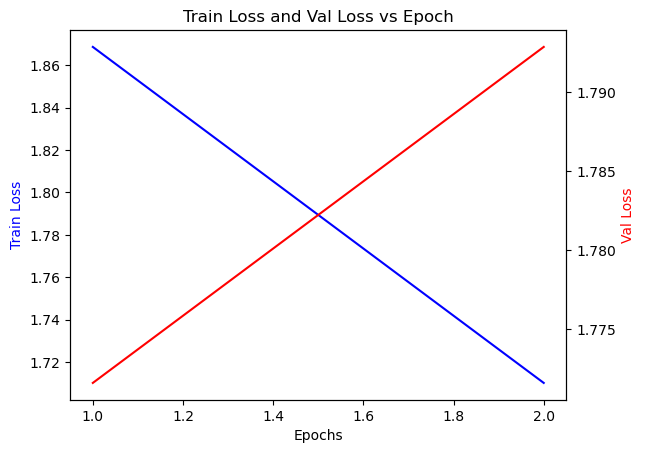

In [30]:
from helper_functions import regression_model_train

# define number of classes for model head
num_classes = 1

# load pretrained model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
# Sigmoid to restrict output [0,1]. Scale it by 10x, and round to nearest whole number and divide by 2 to get 0.5
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes),
                    nn.Sigmoid())

# verify model head
print(model.fc)
print('\n')


# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameters update for the following layers
# for param in model.layer4.parameters():
#     param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True


# define model inputs
target = target
save_model = 'no'
train_loader = train_loader
val_loader = val_loader

loss_criterion = nn.MSELoss(reduction='mean')

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

epochs = 2
patience = 7

result = regression_model_train(target, save_model, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Grade Regression: ResNet152

Sequential(
  (0): Linear(in_features=2048, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=1, bias=True)
  (3): Sigmoid()
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current RMSE: 1.7947
Best RMSE: 1.7947
Starting Epoch: 2
Epoch: 2, Current RMSE: 1.7582
Best RMSE: 1.7582
Training Completed


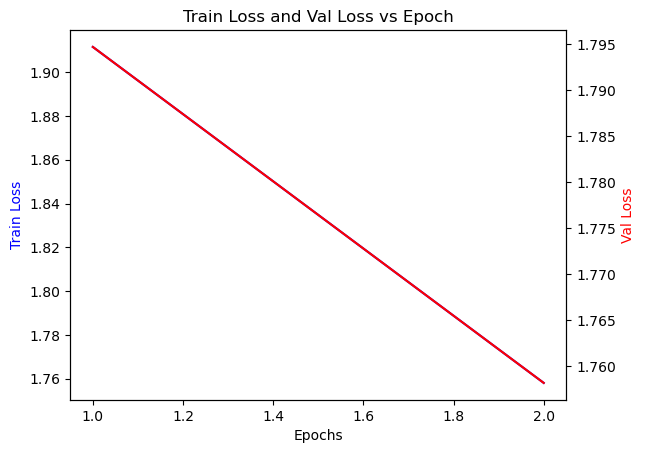

In [31]:
from helper_functions import regression_model_train

# define number of classes for model head
num_classes = 1

# load pretrained model
model = resnet152(weights=ResNet152_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
# Sigmoid to restrict output [0,1]. Scale it by 10x, and round to nearest whole number and divide by 2 to get 0.5
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes),
                    nn.Sigmoid())

# verify model head
print(model.fc)
print('\n')


# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameters update for the following layers
# for param in model.layer2.parameters():
#     param.requires_grad = True

# for param in model.layer3.parameters():
#     param.requires_grad = True

# for param in model.layer4.parameters():
#     param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True


# define model inputs
target = target
save_model = 'no'
train_loader = train_loader
val_loader = val_loader

loss_criterion = nn.MSELoss(reduction='mean')

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

epochs = 2
patience = 7

result = regression_model_train(target, save_model, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Grade Regression: EfficientNet_V2_L

Sequential(
  (0): Linear(in_features=1280, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=1, bias=True)
  (3): Sigmoid()
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current RMSE: 1.8114
Best RMSE: 1.8114
Starting Epoch: 2
Epoch: 2, Current RMSE: 1.7613
Best RMSE: 1.7613
Training Completed


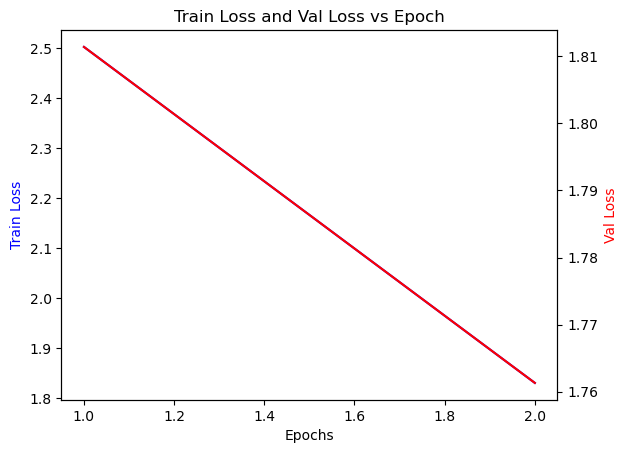

In [32]:
from helper_functions import regression_model_train

# define number of classes for model head
num_classes = 1

# load pretrained model
model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
# Sigmoid to restrict output [0,1]. Scale it by 10x, and round to nearest whole number and divide by 2 to get 0.5
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
                            nn.Linear(in_features, 640),
                            nn.ReLU(),
                            nn.Linear(640, num_classes),
                            nn.Sigmoid())

# verify model head
print(model.classifier)
print('\n')


# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameters update for the following layers
# for param in model.features[7].parameters():
#     param.requires_grad = True

# for param in model.features[8].parameters():
#     param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_model = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

loss_criterion = nn.MSELoss(reduction='mean')

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

epochs = 2
patience = 7

result = regression_model_train(target, save_model, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Grade Regression: RexNet200

Sequential(
  (0): Linear(in_features=2560, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=1, bias=True)
  (3): Sigmoid()
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current RMSE: 1.7028
Best RMSE: 1.7028
Starting Epoch: 2
Epoch: 2, Current RMSE: 1.6747
Best RMSE: 1.6747
Training Completed


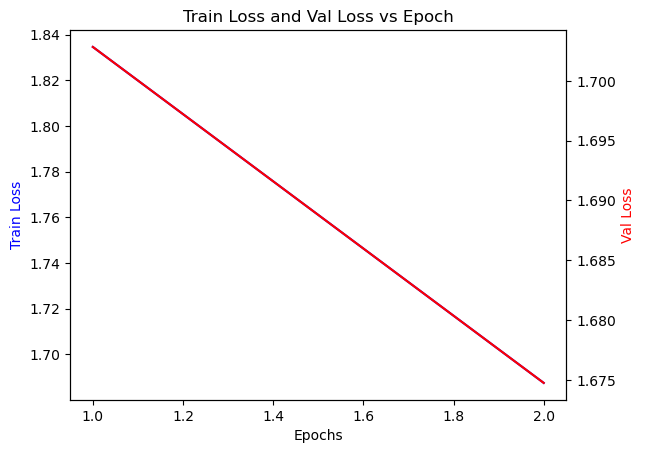

In [33]:
from helper_functions import regression_model_train

# define number of classes for model head
num_classes = 1

# load pretrained model
model = timm.create_model('rexnet_200', pretrained=True, num_classes=num_classes)

# check model architecture
# print(model)

# modify model head layer
# Sigmoid to restrict output [0,1]. Scale it by 10x, and round to nearest whole number and divide by 2 to get 0.5
in_features = model.head.fc.in_features
model.head.fc = nn.Sequential(
                            nn.Linear(in_features, 640),
                            nn.ReLU(),
                            nn.Linear(640, num_classes),
                            nn.Sigmoid())
                        

# verify model head
print(model.head.fc)
print('\n')


# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameters update for the following layers

# for param in model.features[12].parameters():
#     param.requires_grad = True

# for param in model.features[13].parameters():
#     param.requires_grad = True

# for param in model.features[14].parameters():
#     param.requires_grad = True

# for param in model.features[15].parameters():
#     param.requires_grad = True

# for param in model.features[16].parameters():
#     param.requires_grad = True

for param in model.head.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_model = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters())
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

loss_criterion = nn.MSELoss(reduction='mean')

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

epochs = 2
patience = 7

result = regression_model_train(target, save_model, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Grade Regression: VGG16

Sequential(
  (0): Linear(in_features=4096, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=1, bias=True)
  (3): Sigmoid()
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current RMSE: 3.7356
Best RMSE: 3.7356
Starting Epoch: 2
Epoch: 2, Current RMSE: 3.7356
Best RMSE: 3.7356
Training Completed


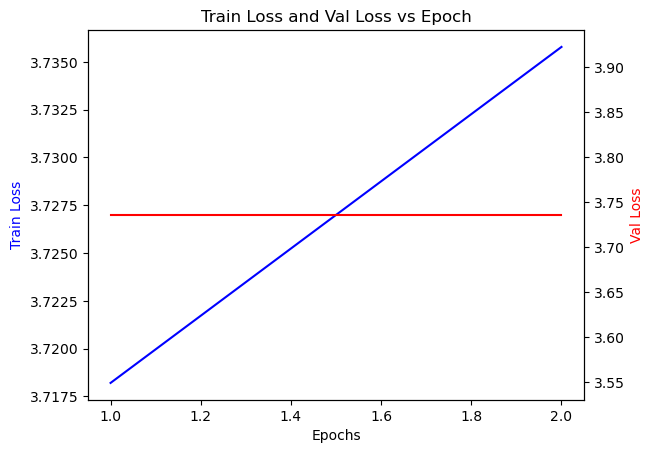

In [34]:
from helper_functions import regression_model_train

# regression output = 1
num_classes = 1

# load pretrained model
model = timm.create_model('vgg16', pretrained=True, num_classes=num_classes)

# check model architecture
# print(model)

# modify model head layer
# Sigmoid to restrict output [0,1]. Scale it by 10x, and round to nearest whole number and divide by 2 to get 0.5
in_features = model.head.fc.in_features
model.head.fc = nn.Sequential(
                            nn.Linear(in_features, 640),
                            nn.ReLU(),
                            nn.Linear(640, num_classes),
                            nn.Sigmoid())

# verify model head
print(model.head.fc)
print('\n')


# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameters update for the following layers
# for param in model.features[21].parameters():
#     param.requires_grad = True

# for param in model.features[24].parameters():
#     param.requires_grad = True

# for param in model.features[26].parameters():
#     param.requires_grad = True

# for param in model.features[28].parameters():
#     param.requires_grad = True

# for module in list(model.modules())[-5:]:
#     for param in module.parameters():
#         param.requires_grad = True

for param in model.head.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_model = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters())
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

loss_criterion = nn.MSELoss(reduction='mean')

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

epochs = 2
patience = 7

result = regression_model_train(target, save_model, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)

### Load saved model for regression evaluation

In [35]:
# load model
model_path = r'..\Img label test\model'
load_model = 'RexNet_RatingNum_epoch_8_val_loss_1.4761.pth'

# define number of classes for model head
num_classes = 1

# load model and head
model = timm.create_model('rexnet_200', pretrained=False, num_classes=num_classes)

in_features = model.head.fc.in_features
model.head.fc = nn.Sequential(
                            nn.Linear(in_features, 640),
                            nn.ReLU(),
                            nn.Linear(640, num_classes),
                            nn.Sigmoid())


# load weights from save model
model.load_state_dict(torch.load(f'{model_path}\{load_model}', weights_only=True))

# reload loaders without sampling replacement
train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

Train samples: 9879
Val samples: 1976
Test samples: 1318


### Grade Prediction EDA And Visualisation

In [36]:
from helper_functions import regression_predict

predict = regression_predict(model, test_loader)

In [37]:
test_df['predicted'] = predict

In [38]:
# calculate RMSE

rmse = root_mean_squared_error(test_df['Grade'], test_df['predicted'])

print(f'Data RMSE: {rmse:.3f}')

Data RMSE: 1.560


In [39]:
# test_df.to_csv('grade_predictions.csv')

# Grade Classification With Pre-trained Models
[TOC](#Table-Of-Contents)

### Data Preparation For Grade Classification

In [40]:
# set target column and the corresponding image and csv file path 
target = 'GradeClass'
img_path = concat_path
csv_path = concat_csv

# set the max sample size per target group. To limit the data used for modelling, as well as reduce imbalanced data
max_sample = 2000

# create df for modelling, restricting each target group sample size
# note: Groupby has a warning that requires explict selection of the grouping columns after groupby to slience the warning, or use include_groups = True/False
raw_data = pd.read_csv(csv_path, usecols=['File_name', 'Grade', 'Side', 'Type'])
raw_data['GradeClass'] = raw_data['Grade'].map(lambda x: grade_dict[x])
data = raw_data.groupby(target, group_keys=False, as_index=False)[['File_name', 'Grade', 'Side', 'Type', 'GradeClass']].apply(lambda x: x if len(x) < max_sample else x.sample(max_sample, random_state=22)).reset_index()
data.drop(columns='index', inplace=True)

# encode categorical to numerical data type
data['Side'] = data['Side'].map(lambda x: side_dict[x])
data['Type'] = data['Type'].map(lambda x: type_dict[x])

# check data shape, distribution, and null values
print(data.info())
print('\n')
print(data[target].value_counts())
print('\n')

# define train/val/test split ratio
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# split data in to train, val and test set
train_df, val_df = train_test_split(data, stratify=data[target], test_size=(1-train_ratio), random_state=22)
val_df, test_df = train_test_split(val_df, stratify=val_df[target], test_size = test_ratio/ (validation_ratio + test_ratio), random_state=22)

# check number of samples in train, val and test
print(f'Train samples: {len(train_df):,}')
print(f'Validation samples: {len(val_df):,}')
print(f'Test samples: {len(test_df):,}')
print('\n')

# create train, val and test data with the images and labels, with corresponding transformation
from helper_functions import CardData

train_data = CardData(img_path, train_df, transform = data_transforms['train'])
val_data = CardData(img_path, val_df, transform = data_transforms['val'])
test_data = CardData(img_path, test_df, transform = data_transforms['val'])


# # establish weight based on the reciprocal of class count (e.g lower class counts have higher weights)
# class_count = train_df[data_column].value_counts()
# sample_weights = [i/class_count[i] for i in train_df[data_column].values]

# # set replacement = True to oversample minority classes
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples= len(train_df), replacement=True)

# create dataloader with weighted sampling
from helper_functions import loader

# train_loader, val_loader, test_loader = loader(train_data, val_data, test_data, sampler)
train_loader, val_loader, test_loader = loader(train_data, val_data, test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   File_name   13173 non-null  object 
 1   Grade       13173 non-null  float64
 2   Side        13173 non-null  int64  
 3   Type        13173 non-null  int64  
 4   GradeClass  13173 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 514.7+ KB
None


GradeClass
17    2000
16    2000
14    2000
12    2000
10    1926
8     1177
6      780
4      464
2      309
0      188
15     103
1       68
3       36
5       35
7       28
13      21
9       21
11      17
Name: count, dtype: int64


Train samples: 9,879
Validation samples: 1,976
Test samples: 1,318


Train samples: 9879
Val samples: 1976
Test samples: 1318


In [41]:
# check tensor shape
images, grade, side, type, gradeclass = next(iter(train_loader))
print(images.shape)
print(grade.shape)
print(side.shape)
print(type.shape)
print(gradeclass.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])


### Grade Classification: ResNet152

Sequential(
  (0): Linear(in_features=2048, out_features=640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=640, out_features=18, bias=True)
)


Starting Epoch: 1
Model Saved
Epoch: 1, Current loss: 2.0136, Current acc:24.1397
Best loss: 2.0136
Starting Epoch: 2
Epoch: 2, Current loss: 1.9584, Current acc:26.2146
Best loss: 1.9584
Training Completed


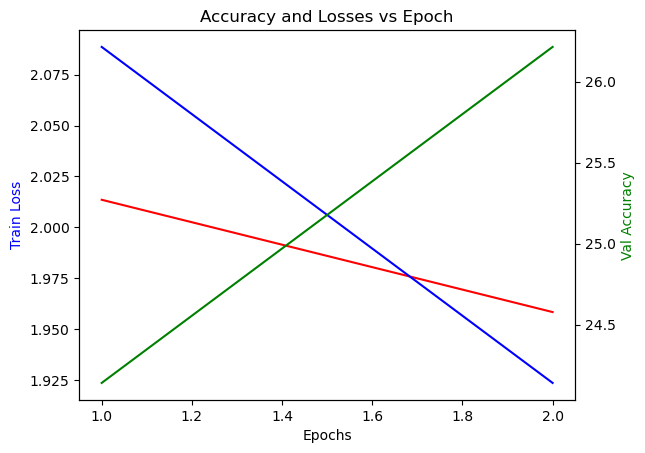

In [42]:
# set up model work flow
from helper_functions import classification_model_train

# define number of classes for model head
num_classes = data[target].nunique()

# load pretrained model
model = resnet152(weights=ResNet152_Weights.DEFAULT)

# check model architecture
# print(model)

# modify model head layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
                    nn.Linear(in_features, 640),
                    nn.ReLU(),
                    nn.Linear(640, num_classes))

# verify model head
print(model.fc)
print('\n')

# Trial and error of unfreezing layers to get lower error and higher accuracy 
# freeze parameters update for all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze parameter update for the following layers
# for param in model.layer2.parameters():
#     param.requires_grad = True

# for param in model.layer3.parameters():
#     param.requires_grad = True

# for param in model.layer4.parameters():
#     param.requires_grad = True

# unfreeze parameter for final layer
for param in model.fc.parameters():
    param.requires_grad = True

# define model inputs
target = target
save_mode = 'no'
train_loader = train_loader
val_loader = val_loader

# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
optimiser = optim.AdamW(model.parameters())

# The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model.
loss_criterion = nn.CrossEntropyLoss()
epochs = 2
patience = 7

# learning rate restart cycle
scheduler = CosineAnnealingWarmRestarts(
    optimiser, 
    T_0 = 10,# number of epochs before cycle restarts
    eta_min= 1e-6
)

result = classification_model_train(target, save_mode, model, train_loader, val_loader, optimiser, scheduler, loss_criterion, epochs, patience)